In [1]:
import sys
sys.path.insert(0, '/tf/utils/')

In [2]:
base_shape_size = 8192
ws = 255
ol = 128
input_shape = (128, 64, 2)

In [3]:
from utils import calculate_stft_magnitude_and_phase, reconstruct_signal_from_stft
from sound import Sound
from data_generators import NoisyTargetGenerator
from artigos.PRIDNet import create_model
import tensorflow as tf
# tf.debugging.set_log_device_placement(True)

from tensorflow.keras.optimizers import Adam

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Audio
from IPython import display
import librosa

In [5]:
sound_base_train = Sound('../../../Dados/Vozes/train/', '../../../Dados/Ruido/train/', base_shape_size)
sound_base_val = Sound('../../../Dados/Vozes/val/', '../../../Dados/Ruido/val/', base_shape_size)

Loading Speech Files: 100%|██████████| 1635/1635 [00:02<00:00, 689.09it/s] 


In [6]:
data_generator_train = NoisyTargetGenerator(sound_base_train.clean_sounds, sound_base_train.noise_sounds)
data_generator_val = NoisyTargetGenerator(sound_base_val.clean_sounds, sound_base_val.noise_sounds)

In [7]:
def generate_images(model, test_input, tar):
    
    prediction = model(test_input, training=True)
    plt.figure(figsize=(22, 7))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Log Power Spectrum - Som ruidoso', 'Log Power Spectrum - Som original', 'Log Power Spectrum - Som filtrado']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(10 * np.log10((display_list[i][..., 0])**2), aspect='auto', cmap='inferno')
        plt.colorbar(format='%+2.0f dB')  # Removi a variável 'im' e 'axs[0]'
        plt.axis('off')
    
    plt.show()

## Estrutura do modelo para 3 canais

![Descrição da imagem](model_structure.png)

In [8]:
# with tf.device('/GPU:0'):
model = create_model(input_shape)

Input = (None, 128, 64, 2)
Conv block = (None, 128, 64, 64)
Channel Attention = (None, 128, 64, 64)
Channel Attention Last CNN = (None, 128, 64, 2)
First phase = (None, 128, 64, 4)

Multi-scale feature extraction = (None, 128, 64, 12)
Kernel Selection Module = (None, 128, 64, 2)


In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 128, 64, 2)  0           []                               
                                ]                                                                 
                                                                                                  
 convolutional_block (Convoluti  (None, 128, 64, 64)  112000     ['input_layer[0][0]']            
 onal_block)                                                                                      
                                                                                                  
 channel_attention (Channel_att  (None, 128, 64, 64)  322        ['convolutional_block[0][0]']    
 ention)                                                                                      

In [10]:
class GenerateImagesCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_val, y_val):
        self.x_val = x_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        indice_aleatorio = np.random.choice(self.x_val.shape[0])
        amostra_noisy_module = self.x_val[indice_aleatorio][np.newaxis, ...]
        amostra_original_module = self.y_val[indice_aleatorio][np.newaxis, ...]
        generate_images(self.model, amostra_noisy_module, amostra_original_module)

In [11]:
# Gera um novo lote de validação para cada época
validation_batch = next(data_generator_val.generate_sample_completo(batch_size=32))
x_val, y_val = validation_batch

In [13]:
steps_per_epoch_train = len(sound_base_train.clean_sounds)
steps_per_epoch_validation = len(sound_base_val.clean_sounds)

In [14]:
best_models_path = "/tf/Etapa 3/Artigos/PRIDNet/model_checkpoints"
callbacks_lst = [
                 tf.keras.callbacks.ModelCheckpoint(filepath=best_models_path+"best_PRIDNet_blindnoise_128x64.h5", save_freq=100, save_weights_only=False),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.0000009, min_delta=0.0001, factor=0.70, patience=3, verbose=1, mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=10),
    GenerateImagesCallback(x_val, y_val)
]

In [33]:
def weighted_msle(y_true, y_pred):
    # Define o peso para penalizar mais as subestimações
    w = 2.0

    # Evita valores negativos adicionando 1 antes de aplicar o log
    log_true = 20 * tf.math.log(y_true + 1)
    log_pred = 20 * tf.math.log(y_pred + 1)

    # Cálculo do erro
    error = log_true - log_pred

    # Aplica pesos diferentes para superestimação e subestimação
    weighted_error = tf.where(error > 0, w * error, error)

    # Retorna a média do erro logarítmico quadrado ponderado
    return tf.reduce_mean(tf.abs(weighted_error))

In [34]:
# model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=Adam(learning_rate=0.0009))
# model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=Adam(learning_rate=0.0009))
model.compile(loss=weighted_msle, optimizer=Adam(learning_rate=0.0009))
# model.compile(loss=tf.keras.losses.MeanSquaredLogarithmicError(), optimizer=Adam())

Epoch 1/100
438/438 [==============================] - ETA: 0s - loss: 2.1367

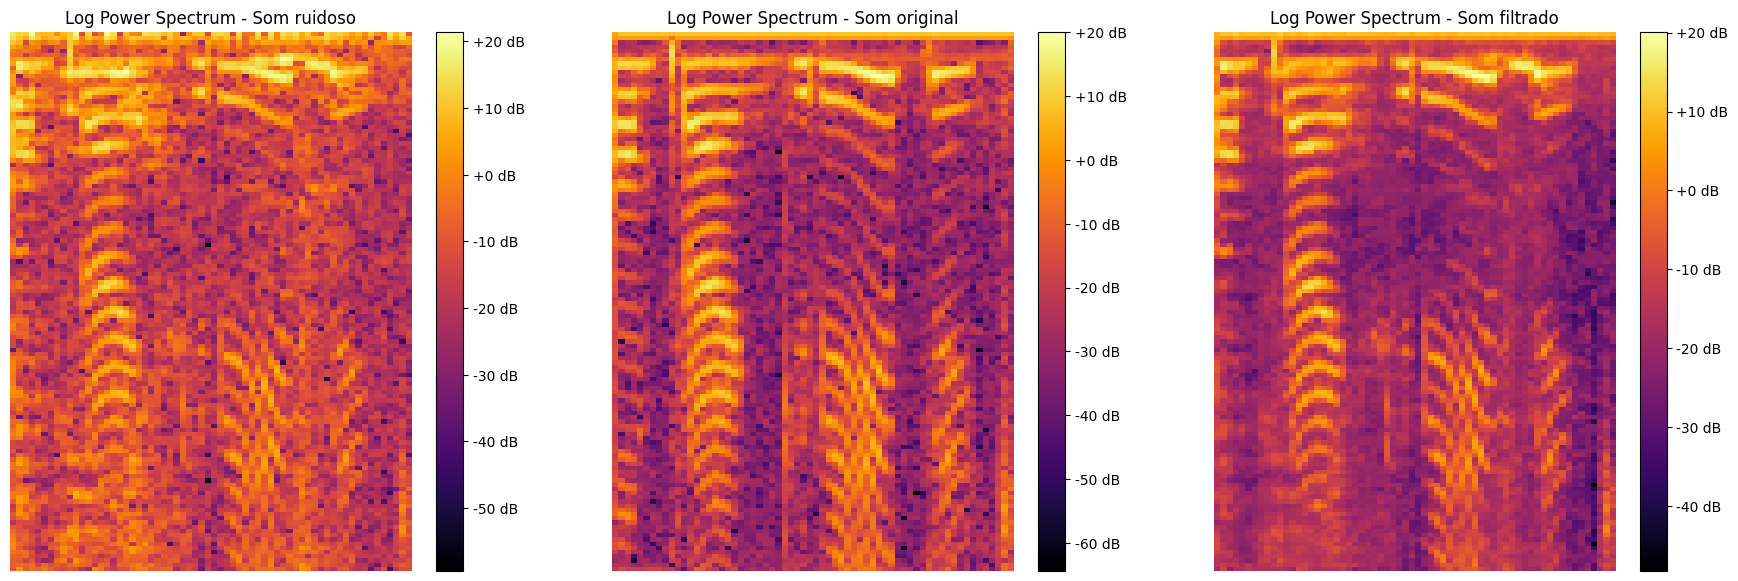

438/438 [==============================] - 341s 632ms/step - loss: 2.1367 - val_loss: 2.2170 - lr: 9.0000e-04
Epoch 2/100
438/438 [==============================] - ETA: 0s - loss: 2.1208

/tmp/ipykernel_288/2126619554.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10 * np.log10((display_list[i][..., 0])**2), aspect='auto', cmap='inferno')


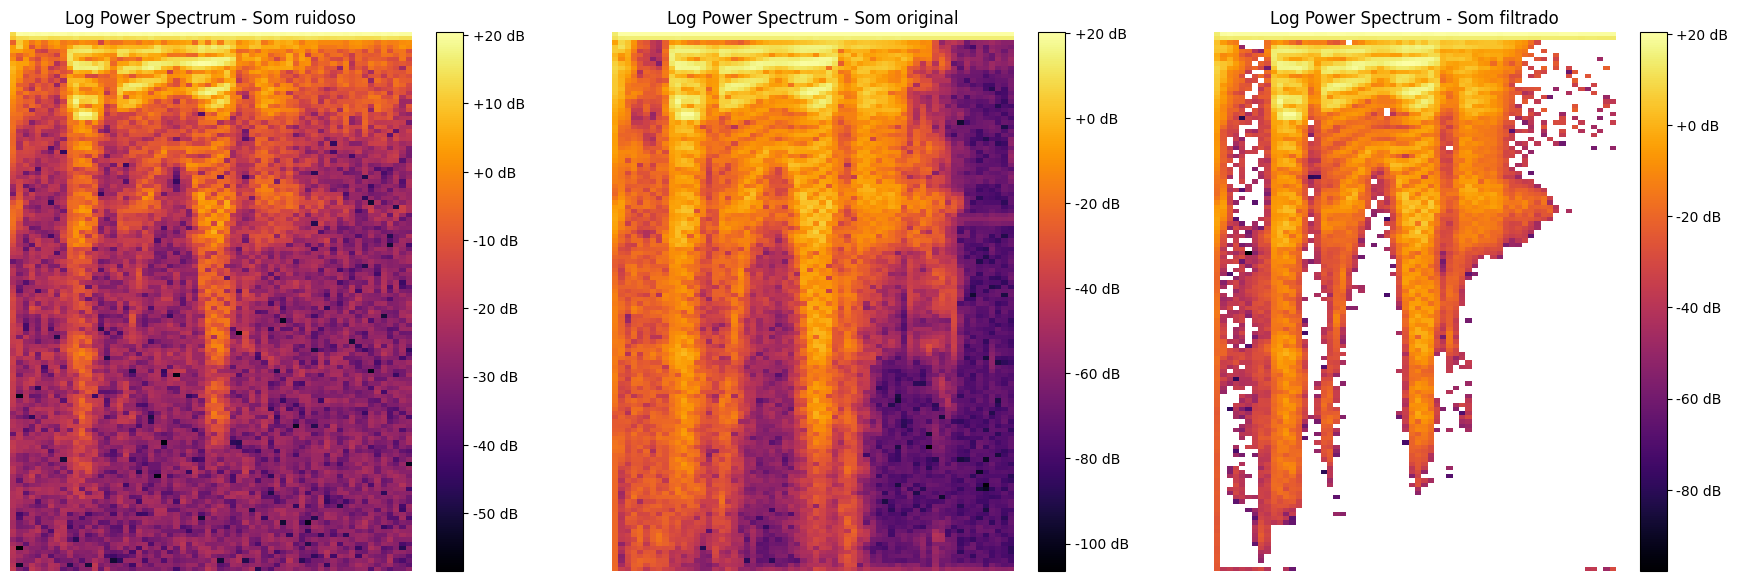

438/438 [==============================] - 275s 627ms/step - loss: 2.1208 - val_loss: 2.2299 - lr: 9.0000e-04
Epoch 3/100
438/438 [==============================] - ETA: 0s - loss: 2.1283

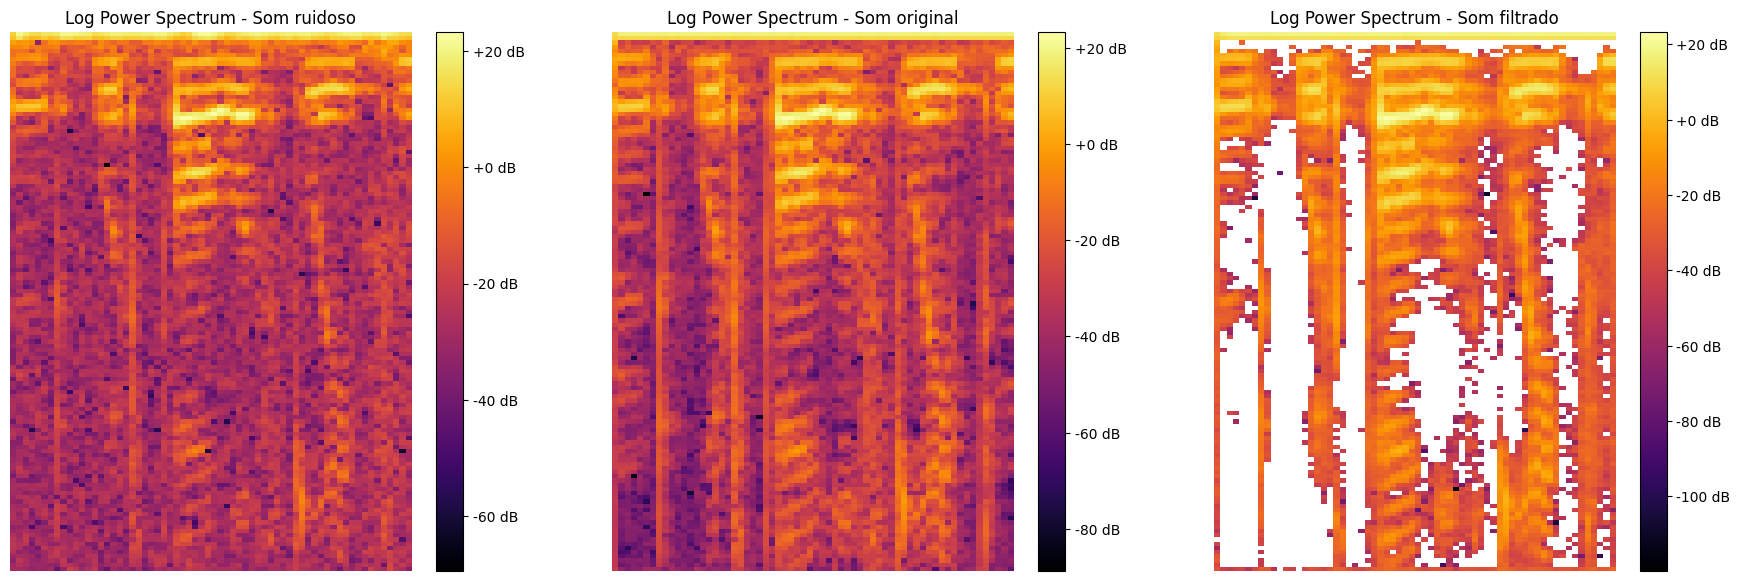

438/438 [==============================] - 275s 627ms/step - loss: 2.1283 - val_loss: 2.2629 - lr: 9.0000e-04
Epoch 4/100
438/438 [==============================] - ETA: 0s - loss: 2.1227
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006299999891780316.


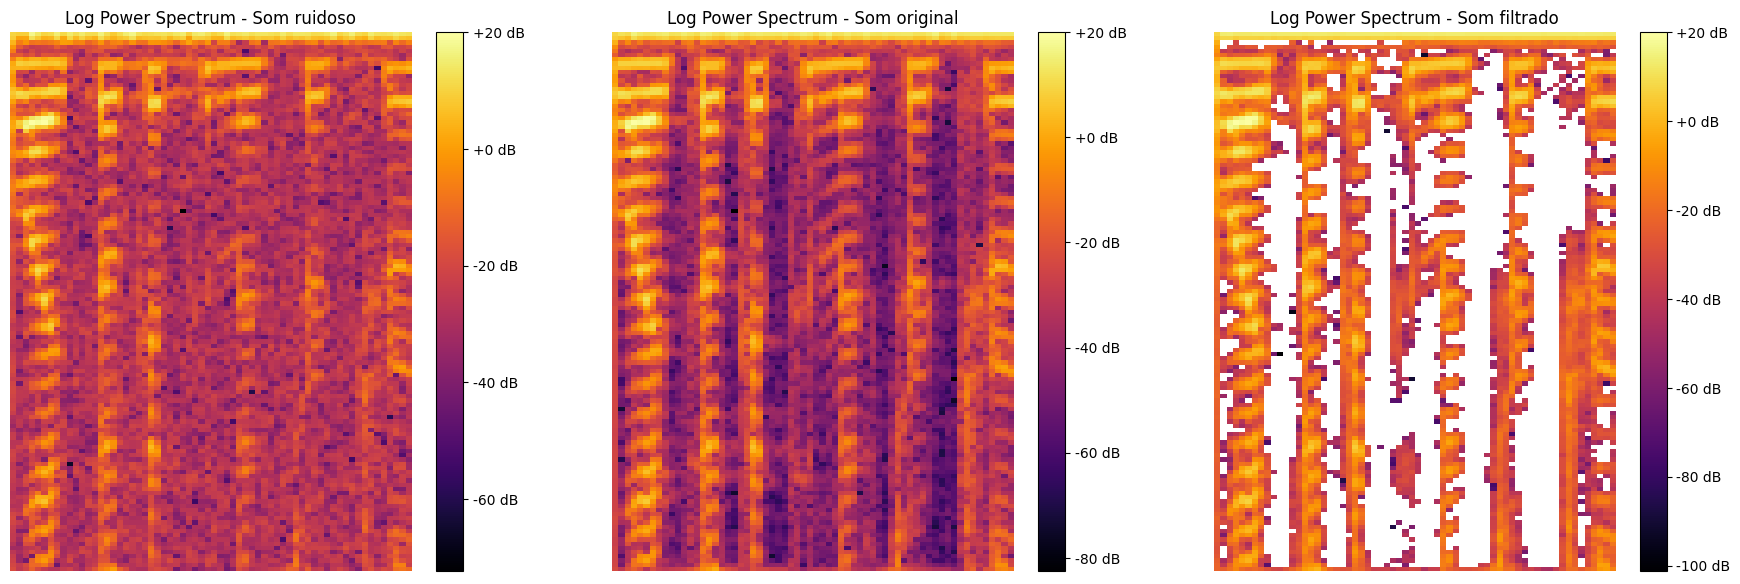

438/438 [==============================] - 276s 629ms/step - loss: 2.1227 - val_loss: 2.2188 - lr: 9.0000e-04
Epoch 5/100
438/438 [==============================] - ETA: 0s - loss: 2.1022

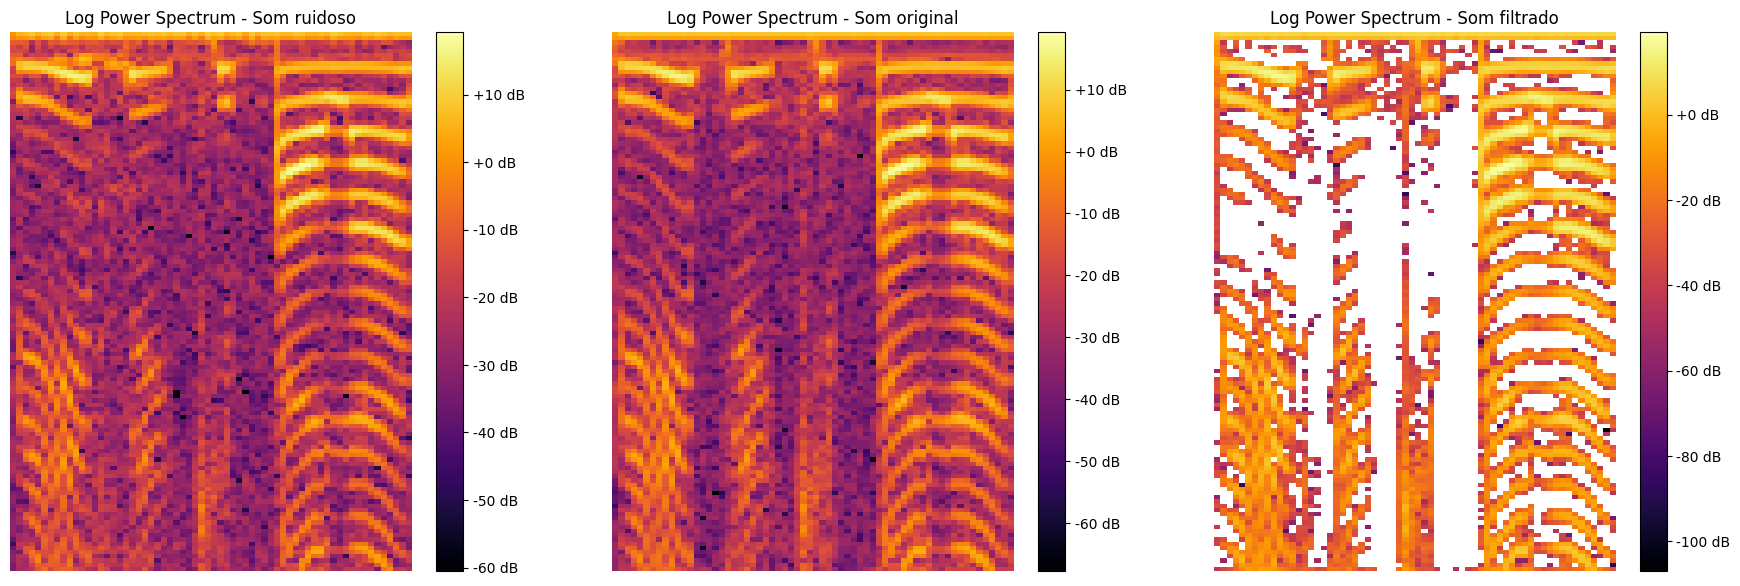

438/438 [==============================] - 274s 626ms/step - loss: 2.1022 - val_loss: 2.1924 - lr: 6.3000e-04
Epoch 6/100
438/438 [==============================] - ETA: 0s - loss: 2.0930

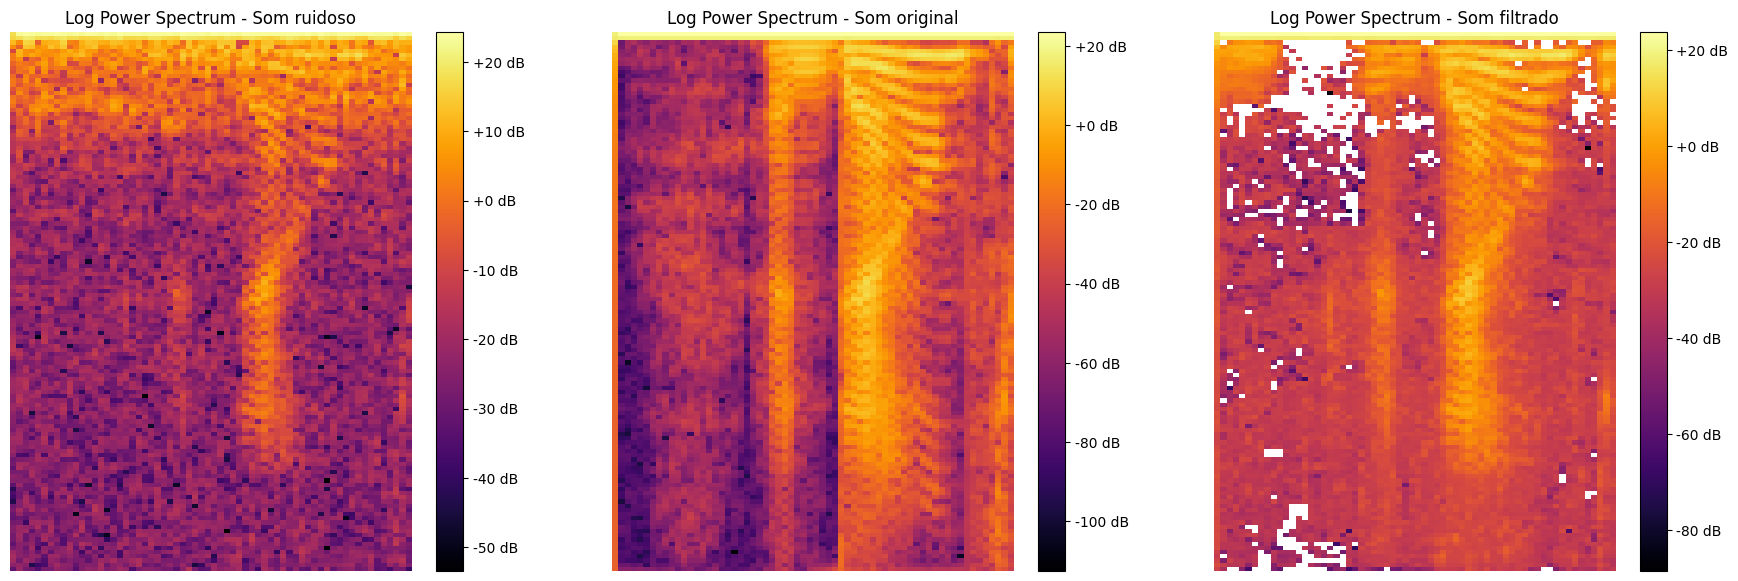

438/438 [==============================] - 275s 629ms/step - loss: 2.0930 - val_loss: 2.1872 - lr: 6.3000e-04
Epoch 7/100
438/438 [==============================] - ETA: 0s - loss: 2.0944

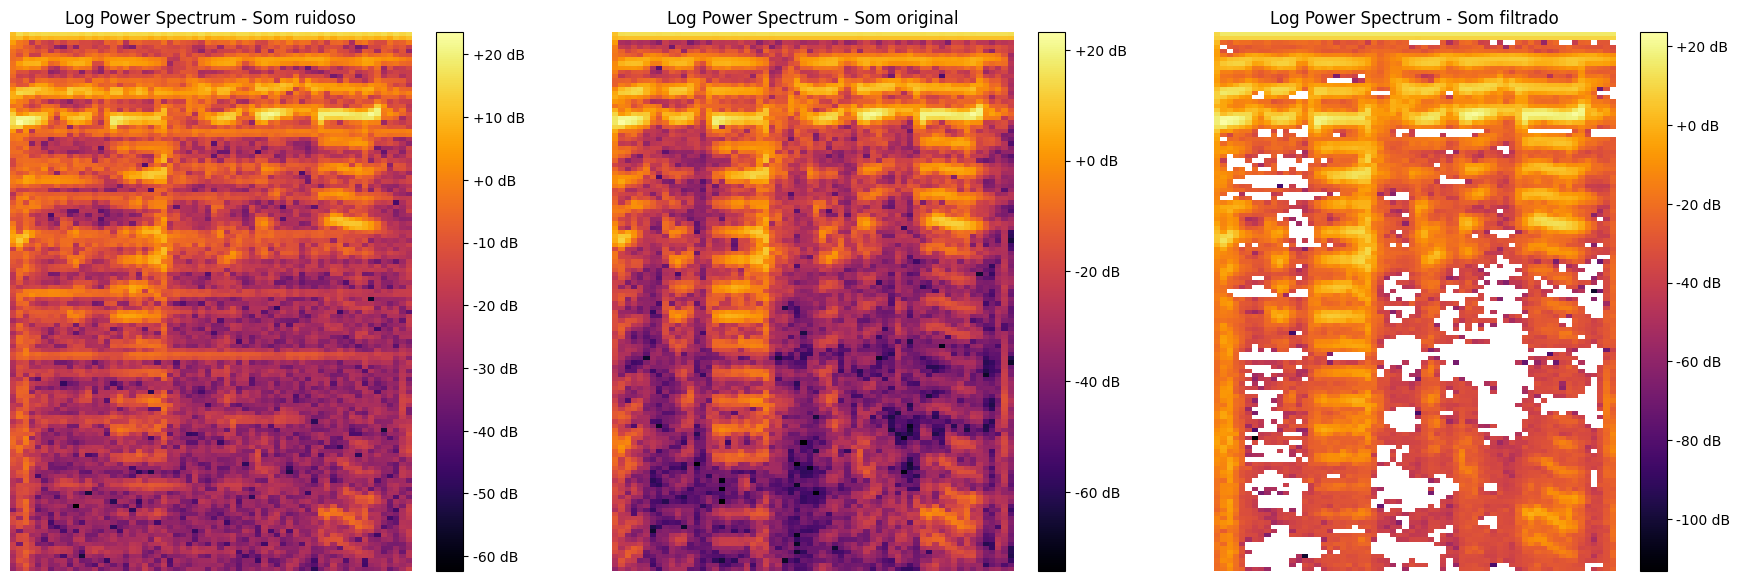

438/438 [==============================] - 274s 626ms/step - loss: 2.0944 - val_loss: 2.2155 - lr: 6.3000e-04
Epoch 8/100
438/438 [==============================] - ETA: 0s - loss: 2.0857

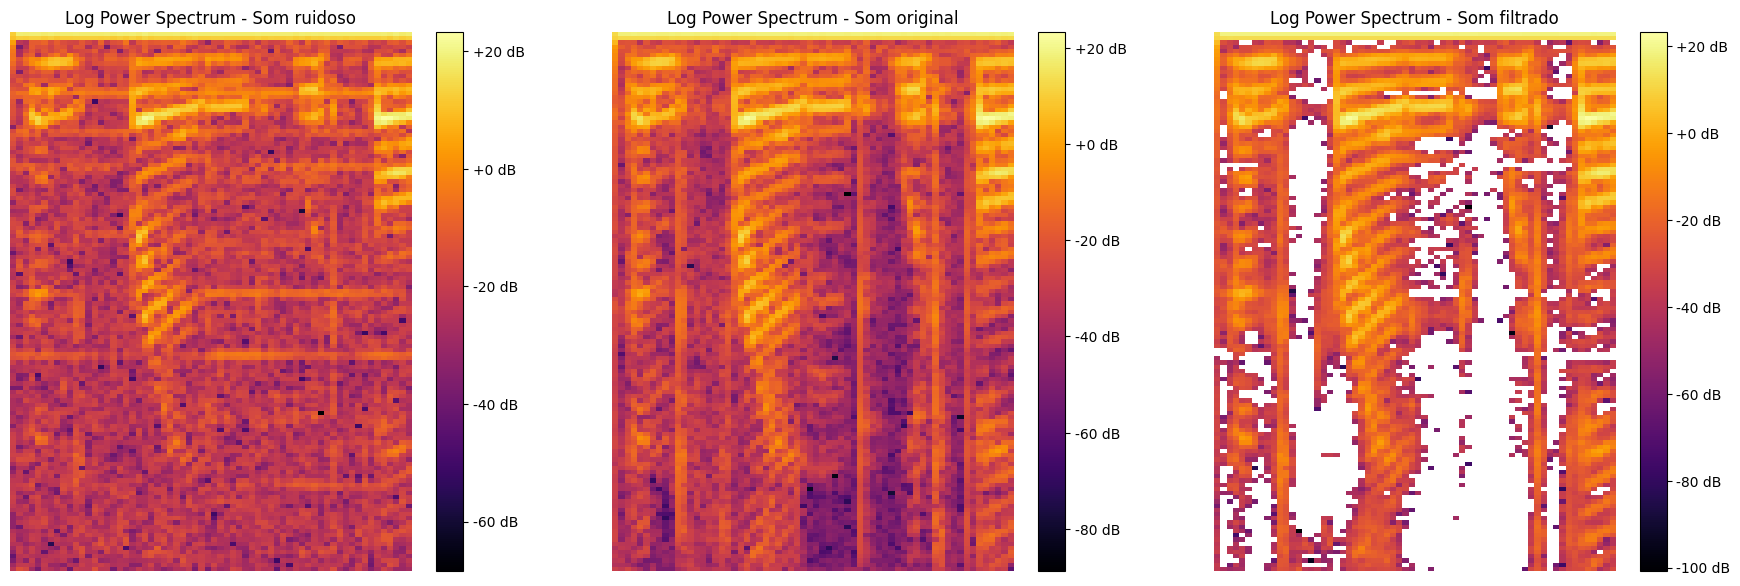

438/438 [==============================] - 274s 626ms/step - loss: 2.0857 - val_loss: 2.2108 - lr: 6.3000e-04
Epoch 9/100
438/438 [==============================] - ETA: 0s - loss: 2.0802
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0004409999761264771.


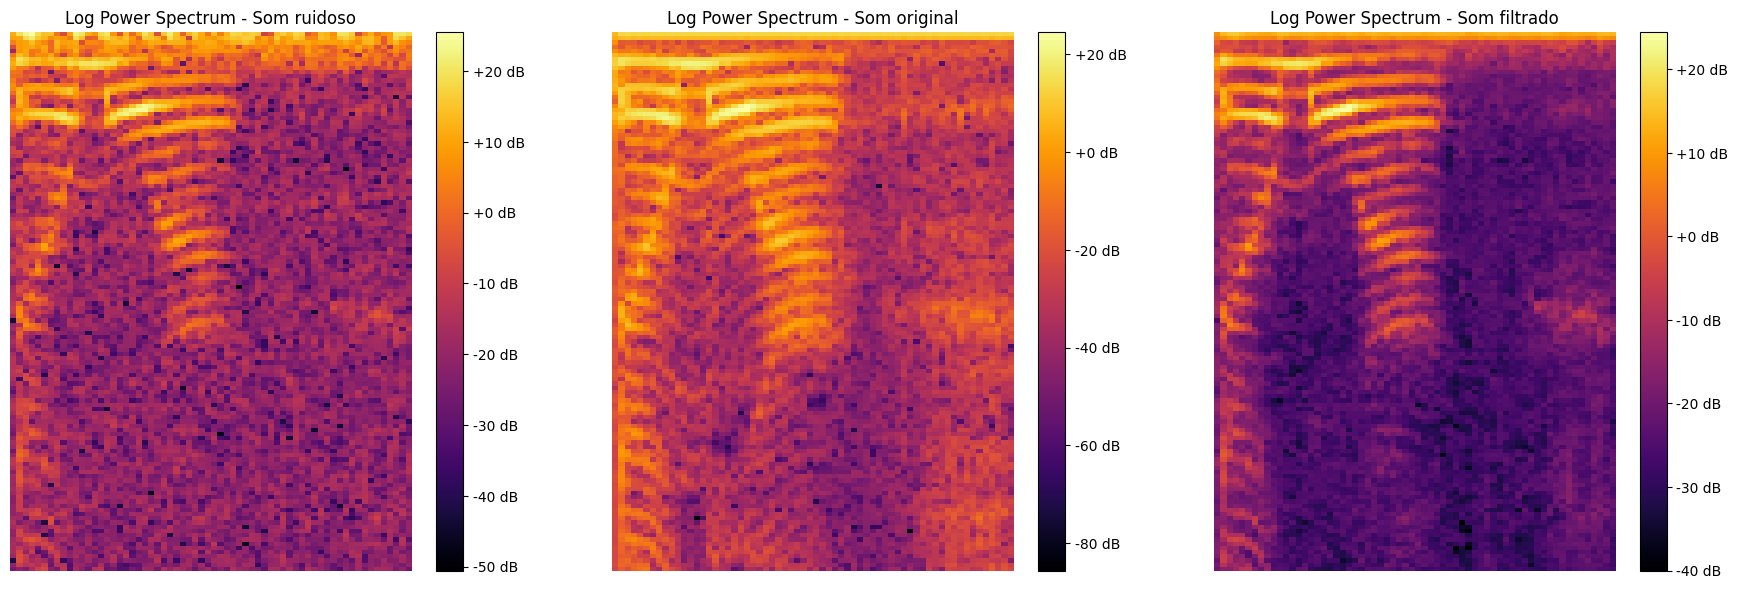

438/438 [==============================] - 275s 628ms/step - loss: 2.0802 - val_loss: 2.2081 - lr: 6.3000e-04
Epoch 10/100
438/438 [==============================] - ETA: 0s - loss: 2.0824

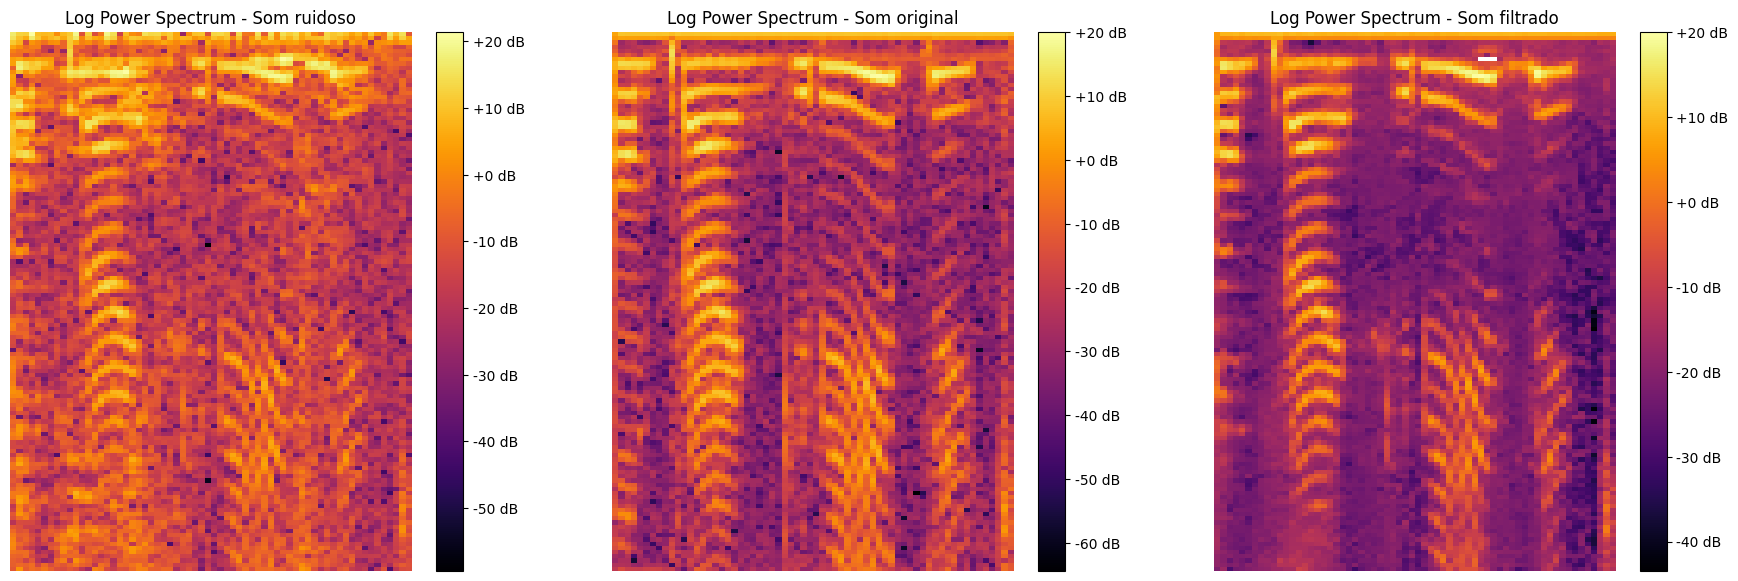

438/438 [==============================] - 269s 614ms/step - loss: 2.0824 - val_loss: 2.1674 - lr: 4.4100e-04
Epoch 11/100
438/438 [==============================] - ETA: 0s - loss: 2.0771

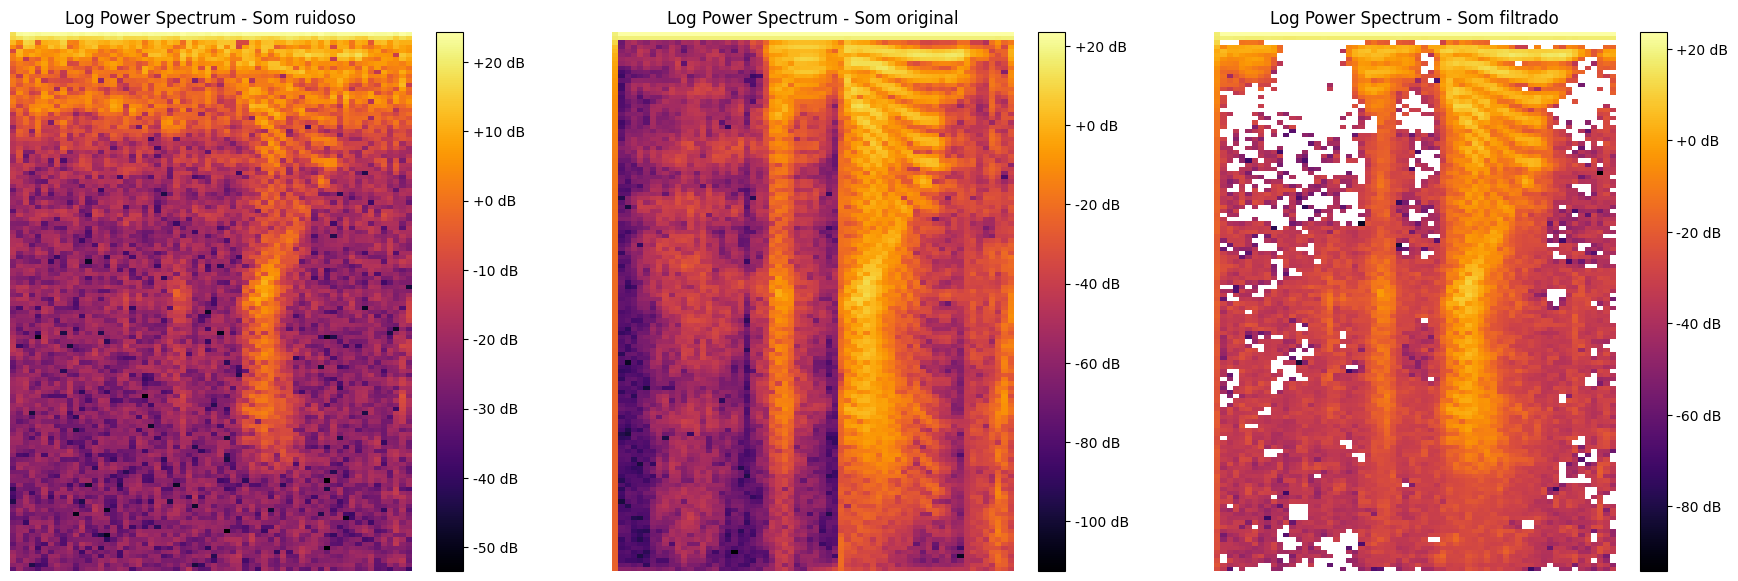

438/438 [==============================] - 269s 614ms/step - loss: 2.0771 - val_loss: 2.1709 - lr: 4.4100e-04
Epoch 12/100
438/438 [==============================] - ETA: 0s - loss: 2.0686

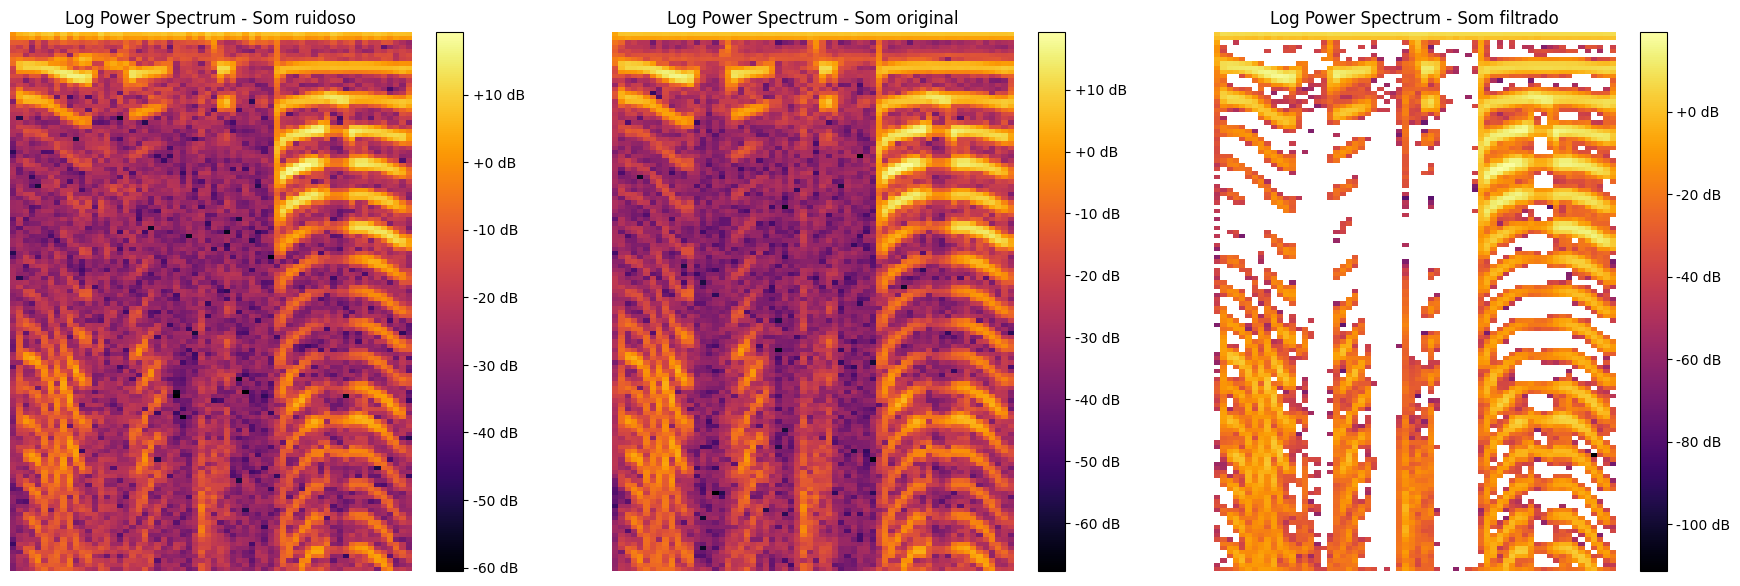

438/438 [==============================] - 270s 616ms/step - loss: 2.0686 - val_loss: 2.1826 - lr: 4.4100e-04
Epoch 13/100
438/438 [==============================] - ETA: 0s - loss: 2.0707
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0003086999873630702.


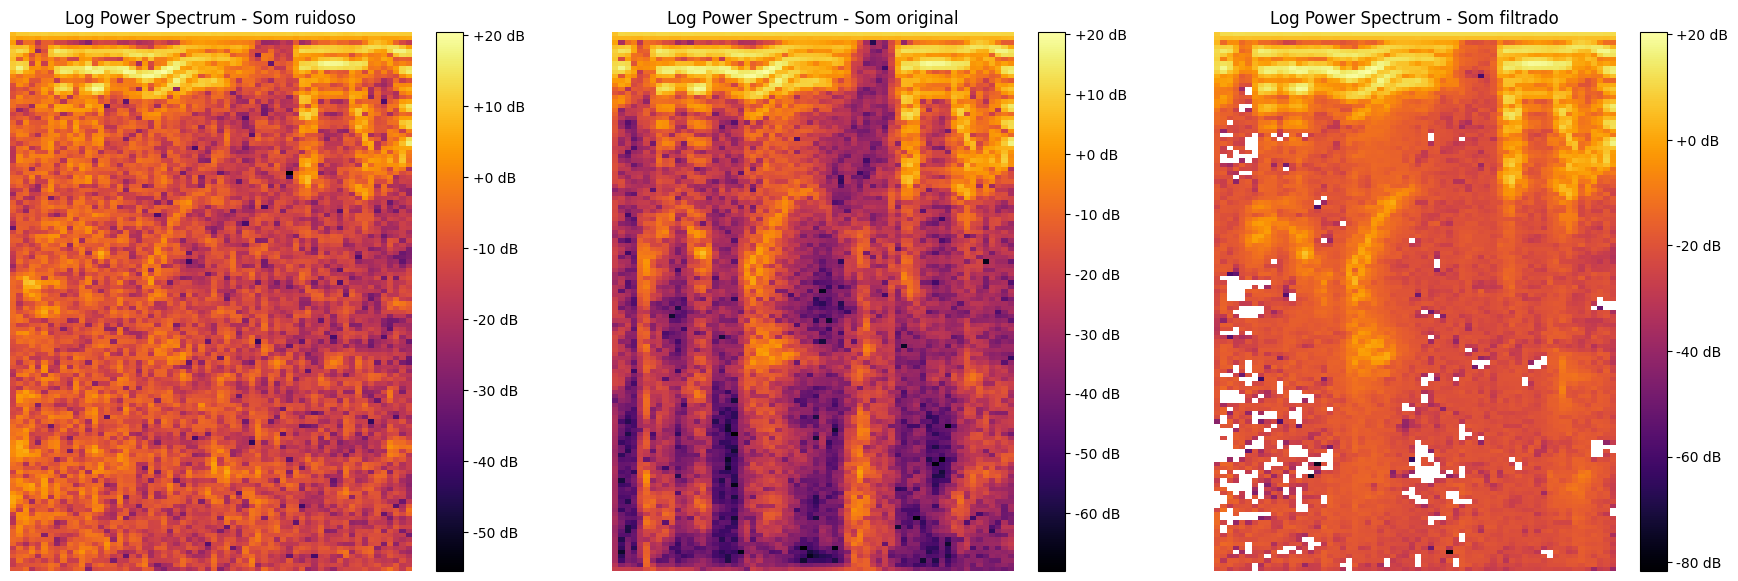

438/438 [==============================] - 269s 613ms/step - loss: 2.0707 - val_loss: 2.1711 - lr: 4.4100e-04
Epoch 14/100
438/438 [==============================] - ETA: 0s - loss: 2.0645

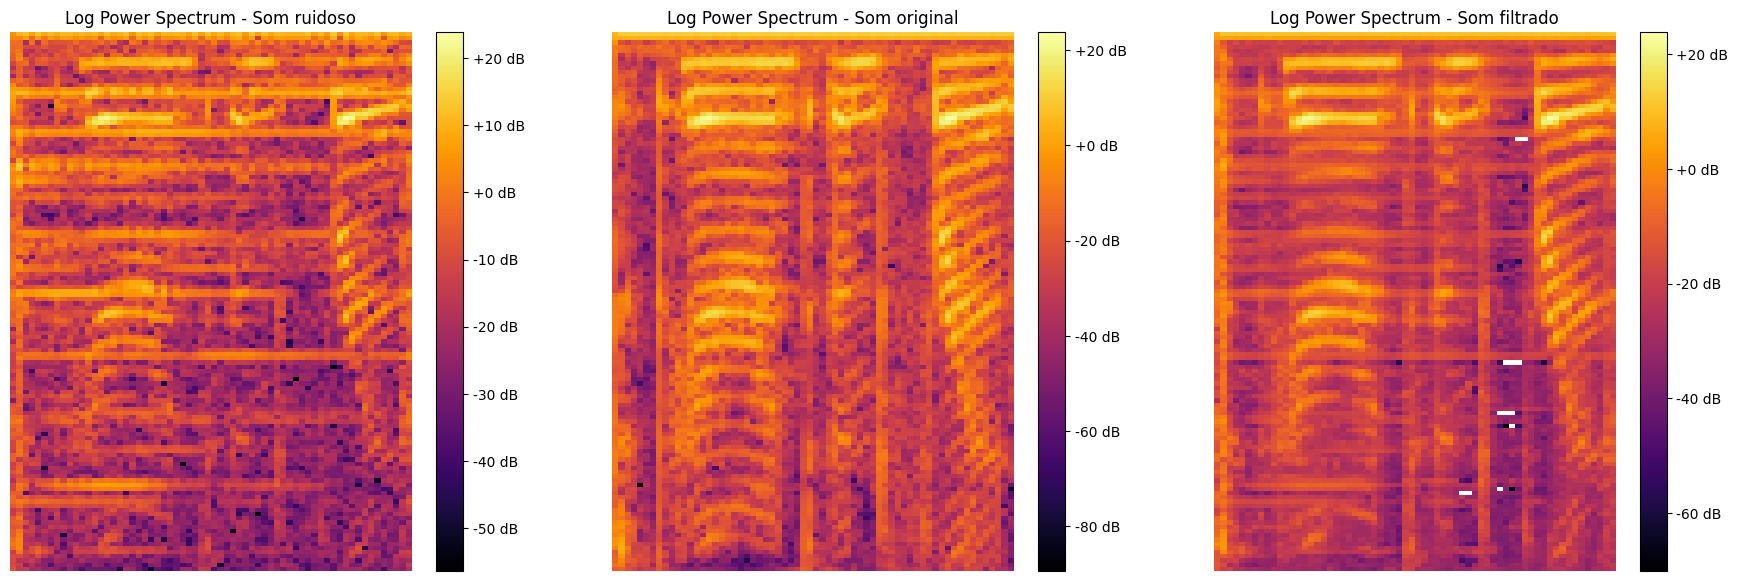

438/438 [==============================] - 270s 616ms/step - loss: 2.0645 - val_loss: 2.1612 - lr: 3.0870e-04
Epoch 15/100
438/438 [==============================] - ETA: 0s - loss: 2.0647

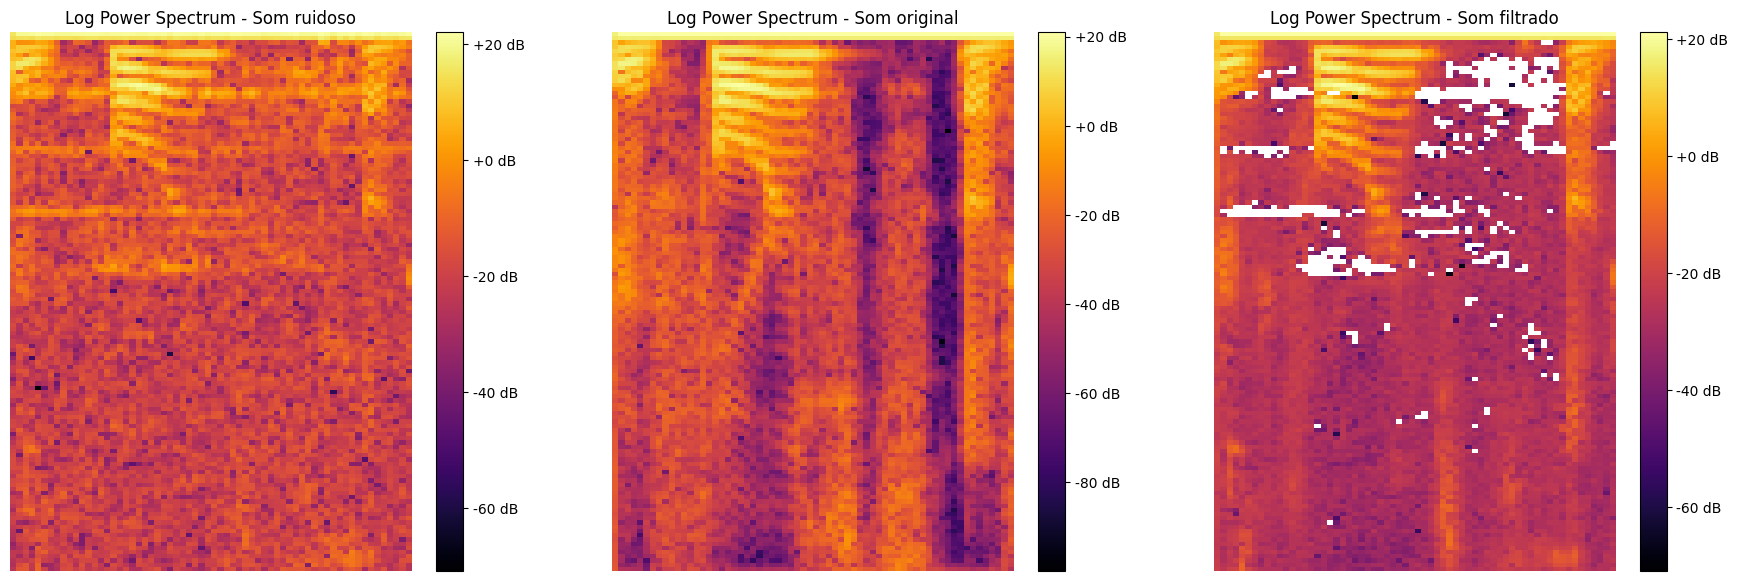

438/438 [==============================] - 269s 613ms/step - loss: 2.0647 - val_loss: 2.1606 - lr: 3.0870e-04
Epoch 16/100
438/438 [==============================] - ETA: 0s - loss: 2.0610

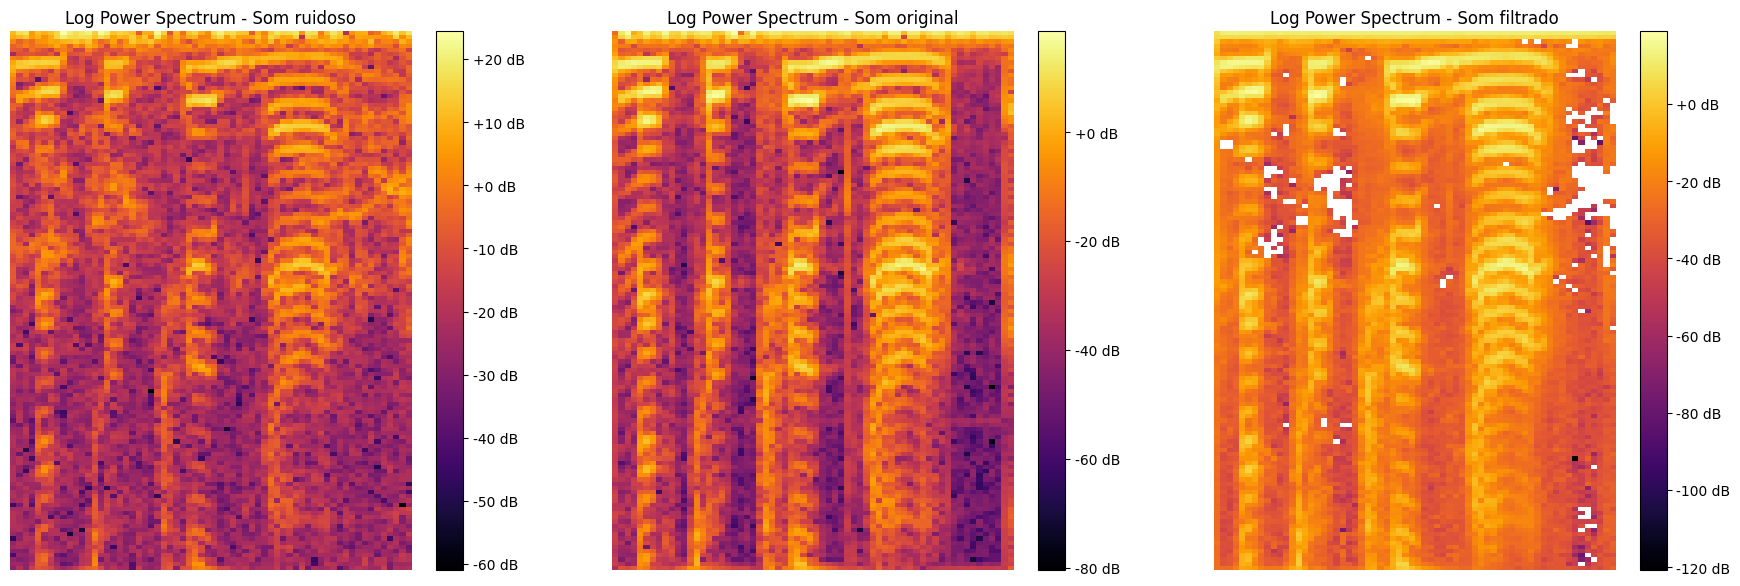

438/438 [==============================] - 268s 613ms/step - loss: 2.0610 - val_loss: 2.1576 - lr: 3.0870e-04
Epoch 17/100
438/438 [==============================] - ETA: 0s - loss: 2.0561

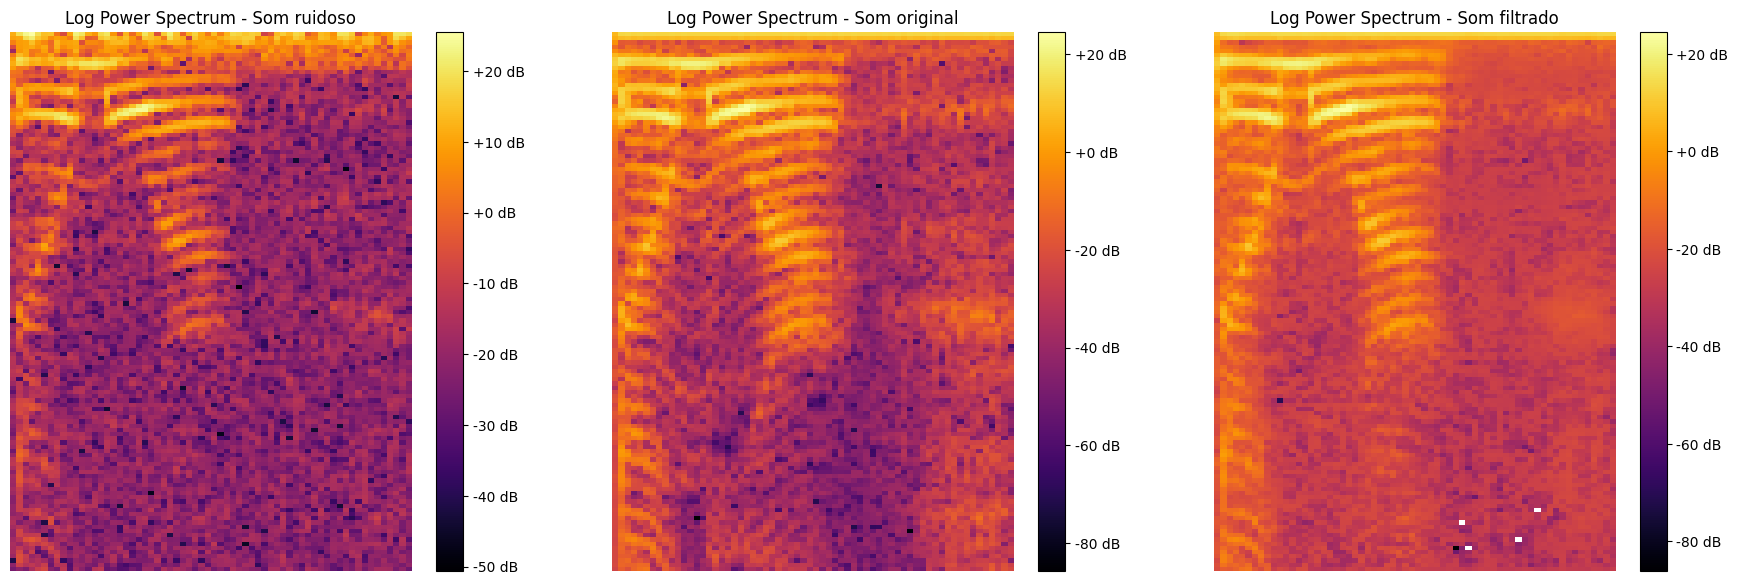

438/438 [==============================] - 270s 616ms/step - loss: 2.0561 - val_loss: 2.1596 - lr: 3.0870e-04
Epoch 18/100
438/438 [==============================] - ETA: 0s - loss: 2.0597

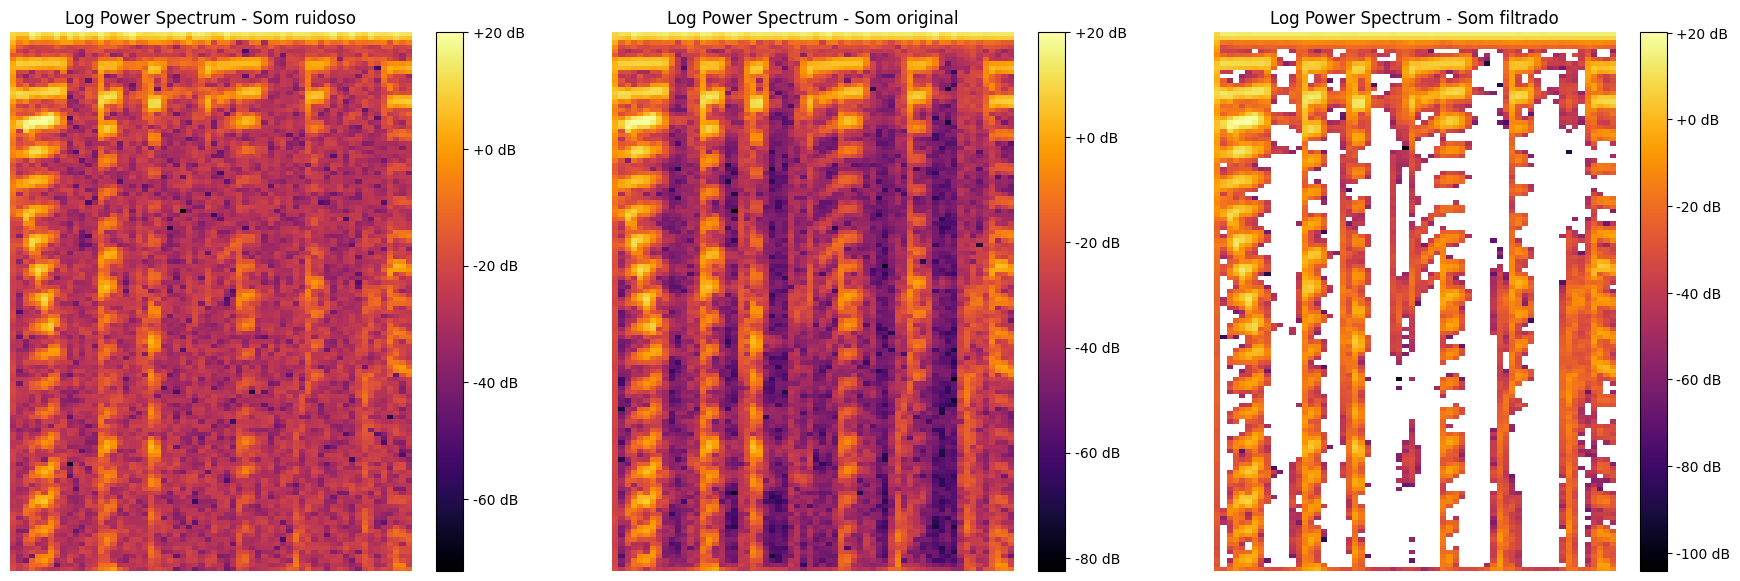

438/438 [==============================] - 275s 627ms/step - loss: 2.0597 - val_loss: 2.1648 - lr: 3.0870e-04
Epoch 19/100
438/438 [==============================] - ETA: 0s - loss: 2.0591

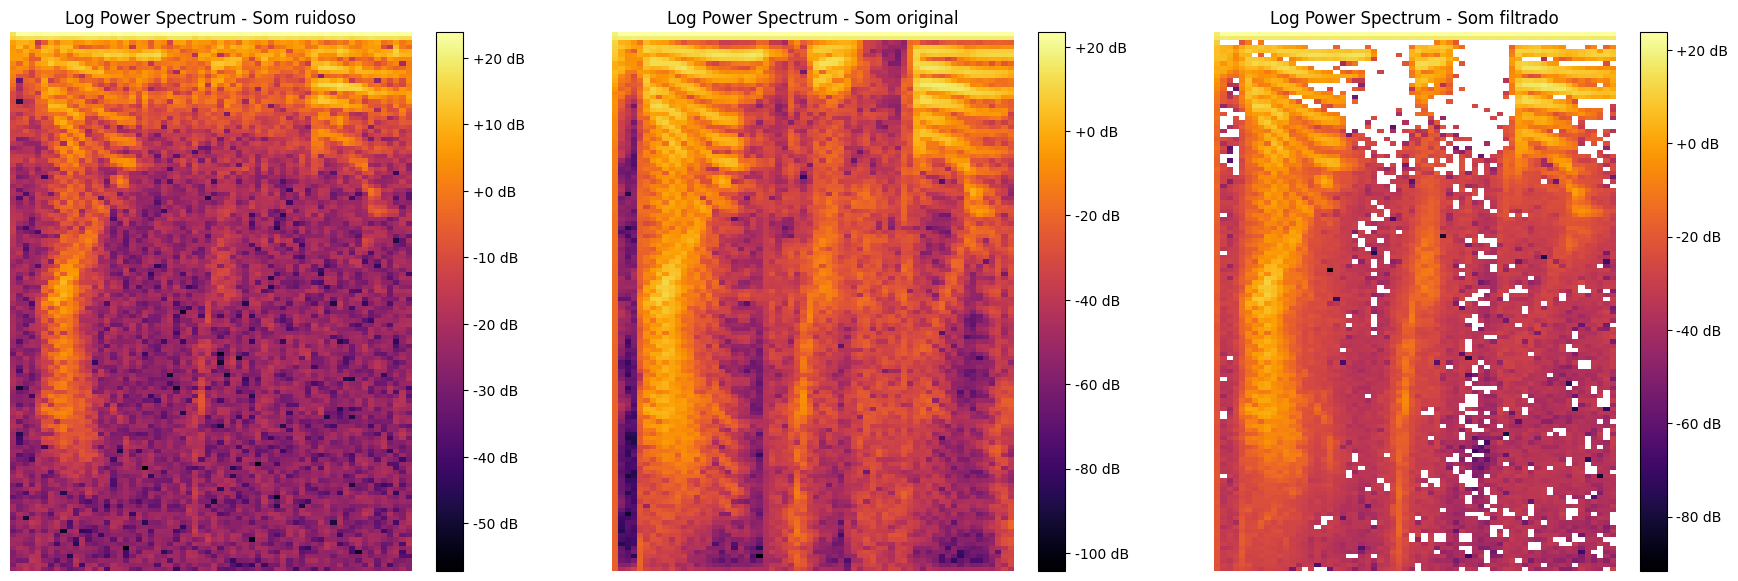

438/438 [==============================] - 275s 629ms/step - loss: 2.0591 - val_loss: 2.1522 - lr: 3.0870e-04
Epoch 20/100
438/438 [==============================] - ETA: 0s - loss: 2.0578

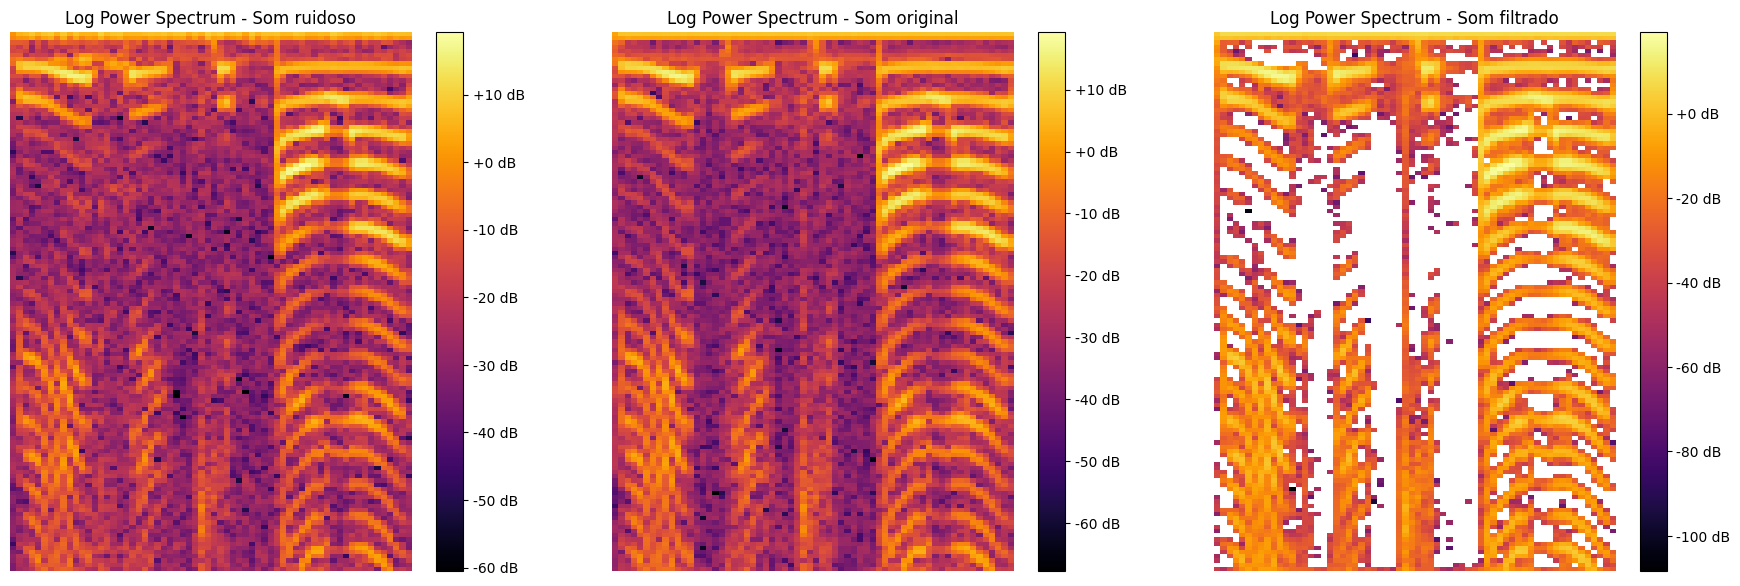

438/438 [==============================] - 276s 630ms/step - loss: 2.0578 - val_loss: 2.1536 - lr: 3.0870e-04
Epoch 21/100
438/438 [==============================] - ETA: 0s - loss: 2.0575

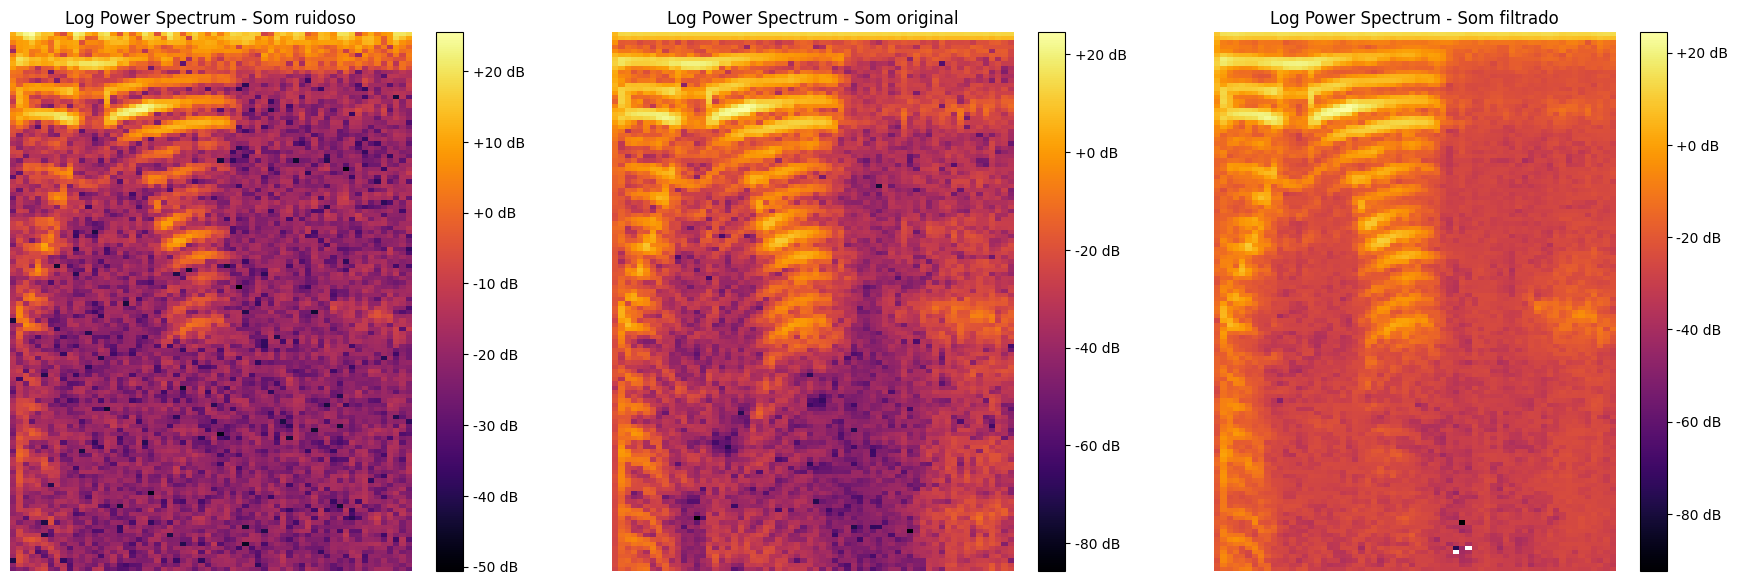

438/438 [==============================] - 275s 628ms/step - loss: 2.0575 - val_loss: 2.1527 - lr: 3.0870e-04
Epoch 22/100
438/438 [==============================] - ETA: 0s - loss: 2.0572
Epoch 22: ReduceLROnPlateau reducing learning rate to 0.00021608999522868542.


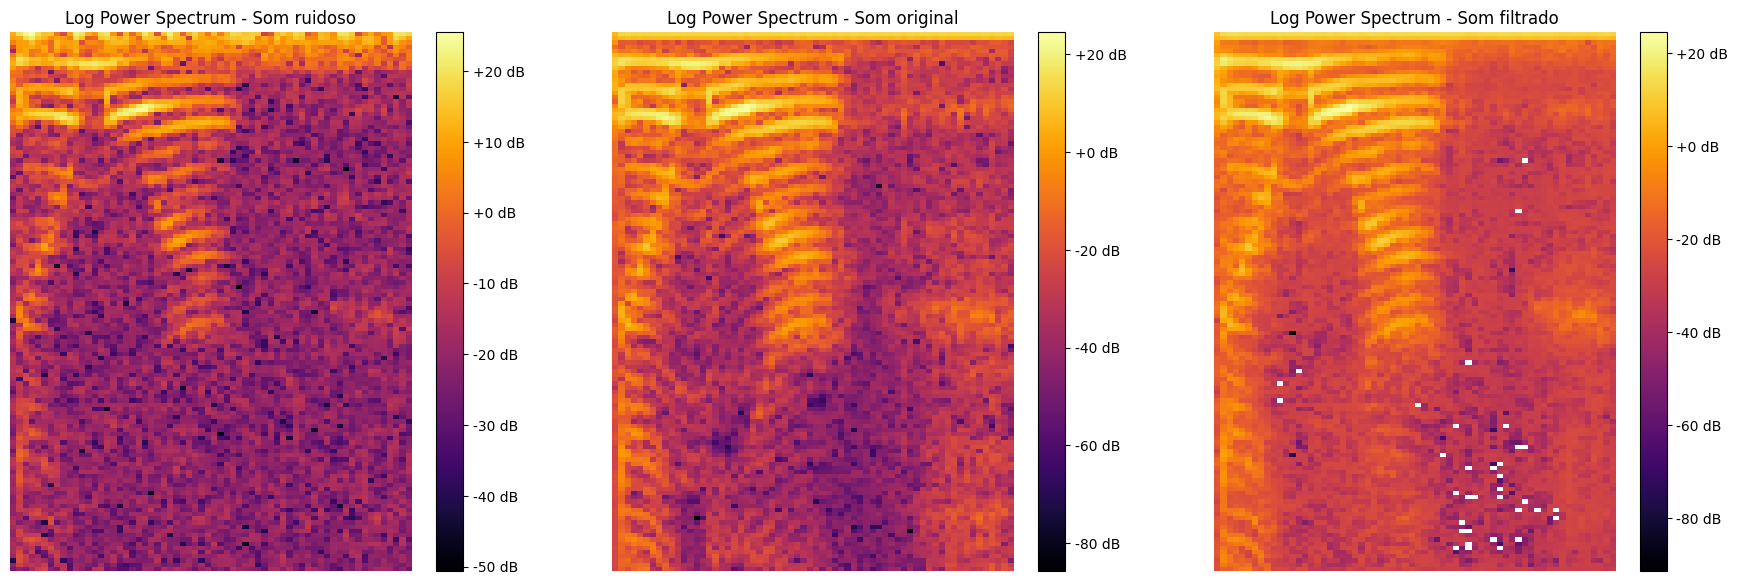

438/438 [==============================] - 274s 626ms/step - loss: 2.0572 - val_loss: 2.1859 - lr: 3.0870e-04
Epoch 23/100
438/438 [==============================] - ETA: 0s - loss: 2.0500

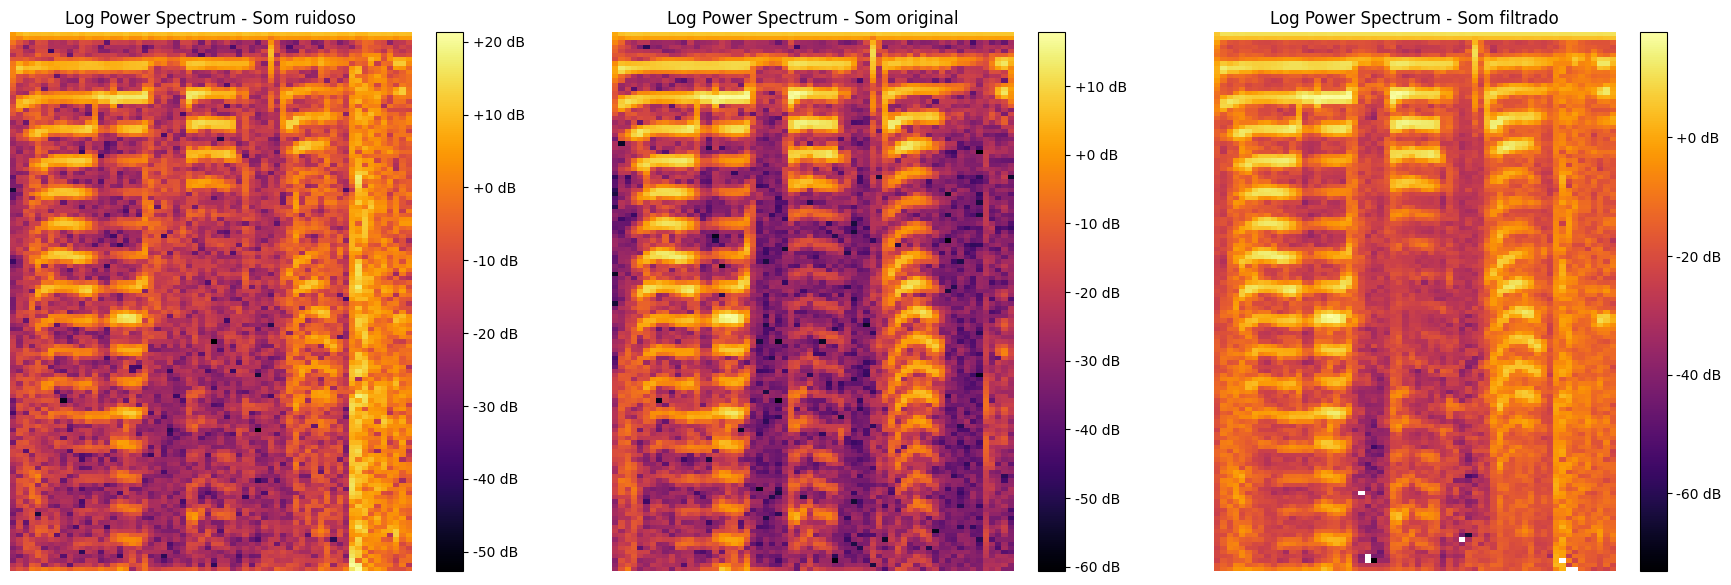

438/438 [==============================] - 269s 614ms/step - loss: 2.0500 - val_loss: 2.1666 - lr: 2.1609e-04
Epoch 24/100
438/438 [==============================] - ETA: 0s - loss: 2.0417

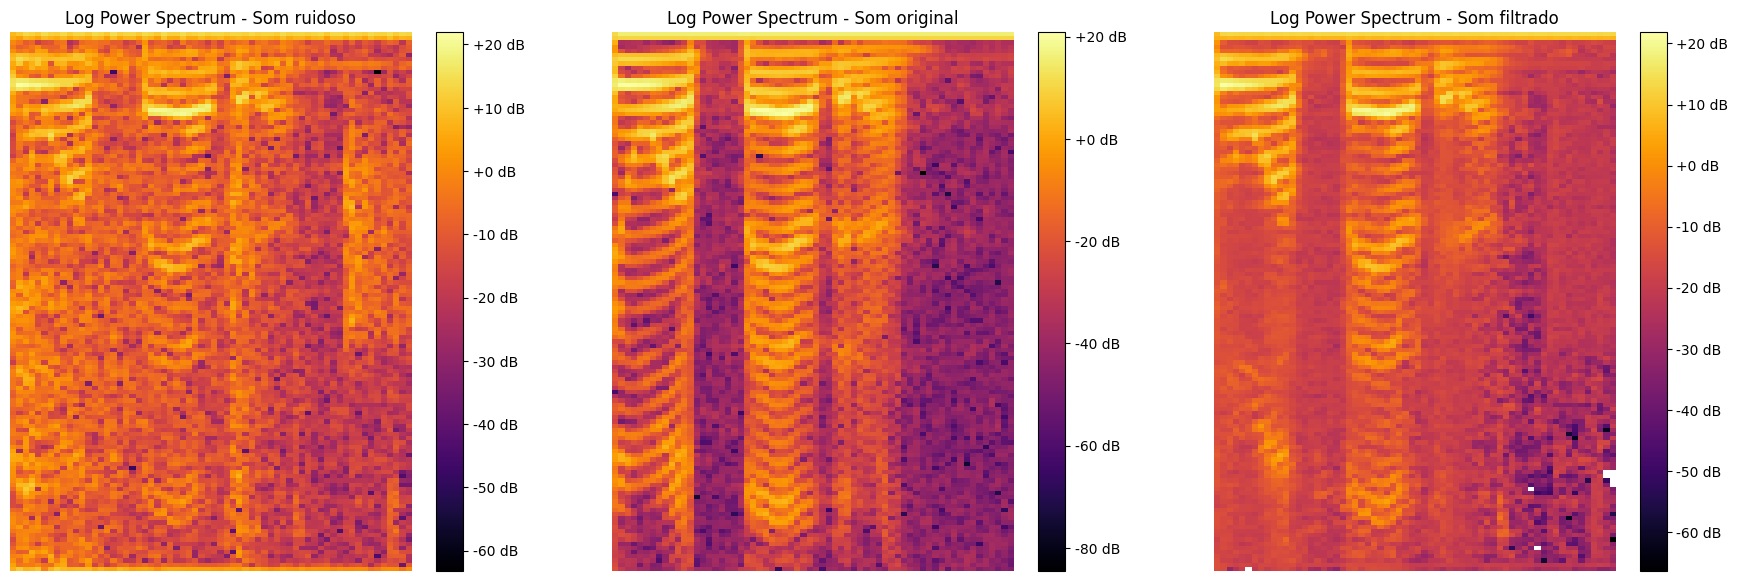

438/438 [==============================] - 269s 615ms/step - loss: 2.0417 - val_loss: 2.1545 - lr: 2.1609e-04
Epoch 25/100
152/438 [=========>....................] - ETA: 2:56 - loss: 2.0460

In [ ]:
batch_size = 64
steps_per_epoch = len(sound_base_train.clean_sounds) // batch_size
epochs = 100

model.fit(data_generator_train.generate_sample_completo(batch_size=batch_size, include_clean=False),
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          validation_data=data_generator_val.generate_sample_completo(batch_size=batch_size, include_clean=False),
          callbacks=callbacks_lst
         )

In [ ]:
validation_batch = next(data_generator_val.generate_sample_completo(batch_size=8))
x_test, y_test = validation_batch

x_test = x_test[0, ...]
y_test = y_test[0, ...]

x_test = x_test[np.newaxis, ...]
y_test = y_test[np.newaxis, ...]

In [ ]:
print(np.max(x_test[:, :, : , 0]))
print(np.min(x_test[:, :, : , 0]))
print(np.max(y_test[:, :, : , 0]))
print(np.min(y_test[:, :, : , 0]))

In [ ]:
F_f = model.predict(x_test)

In [ ]:
print(np.max(F_f))
print(np.min(F_f))
print(F_f.shape)

In [ ]:
A = y_test.reshape(y_test.shape[1], y_test.shape[2], y_test.shape[3])[:, :, 0]
phi = (y_test.reshape(y_test.shape[1], y_test.shape[2], y_test.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

A_f = F_f.reshape(F_f.shape[1], F_f.shape[2], F_f.shape[3])[:, :, 0]
phi_f = (F_f.reshape(F_f.shape[1], F_f.shape[2], F_f.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

A_n = x_test.reshape(x_test.shape[1], x_test.shape[2], x_test.shape[3])[:, :, 0]
phi_n = (x_test.reshape(x_test.shape[1], x_test.shape[2], x_test.shape[3])[:, :, 1] - 0.5) * 2 * np.pi

In [ ]:
print(np.max(A_f))
print(np.max(phi_f))
print(np.min(A_f))
print(np.min(phi_f))

In [ ]:
generate_images(model, x_test, y_test)

In [ ]:
s = reconstruct_signal_from_stft(A, phi)
s_n = reconstruct_signal_from_stft(A_n, phi_n)
s_f = reconstruct_signal_from_stft(A_f, phi_f)

In [ ]:
# Criando figuras e eixos separados para cada array
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

# Plotando o primeiro array
ax1.plot(s)
ax1.set_ylabel('Sinal de voz ruidoso')

# Plotando o primeiro array
ax2.plot(s_n)
ax2.set_ylabel('Sinal de voz ruidoso')

ax3.plot(s_f)
ax3.set_ylabel('Sinal de voz filtrado')

# Exibindo os gráficos
plt.show()

In [ ]:
Audio(data=s, rate=8000)

In [ ]:
Audio(data=s_n, rate=8000)

In [ ]:
Audio(data=s_f, rate=8000)